##ThinkDSP

This notebook contains solutions to exercises in Chapter 10: Signals and Systems

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

PI2 = 2 * np.pi

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

**Exercise:** In this chapter I describe convolution as the sum of shifted,
scaled copies of a signal.  Strictly speaking, this operation is
*linear* convolution, which does not assume that the signal
is periodic.

But when we multiply the
DFT of the signal by the transfer function, that operation corresponds
to *circular* convolution, which assumes that the signal is
periodic.  As a result, you might notice that the output contains
an extra note at the beginning, which wraps around from the end.

Fortunately, there is a standard solution to this problem.  If you
add enough zeros to the end of the signal before computing the DFT,
you can avoid wrap-around and compute a linear convolution.

Modify the example in `chap10soln.ipynb` and confirm that zero-padding
eliminates the extra note at the beginning of the output.

*Solution:* I'll truncate both signals to $2^{16}$ elements, then zero-pad them to $2^{17}$.  Using powers of two makes the FFT algorithm most efficient.

Here's the impulse response:

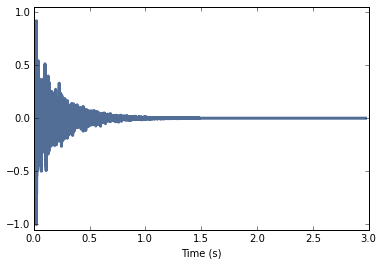

In [6]:
response = thinkdsp.read_wave('180960__kleeb__gunshot.wav')

start = 0.12
response = response.segment(start=start)
response.shift(-start)

response.truncate(2**16)
response.zero_pad(2**17)

response.normalize()
response.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

And its spectrum:

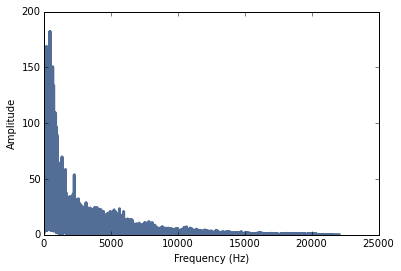

In [7]:
transfer = response.make_spectrum()
transfer.plot()
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude')

Here's the signal:

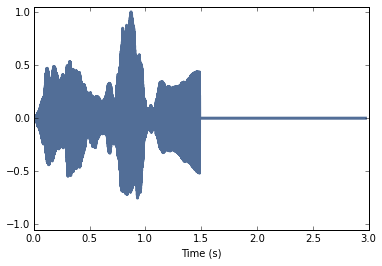

In [9]:
violin = thinkdsp.read_wave('92002__jcveliz__violin-origional.wav')

start = 0.11
violin = violin.segment(start=start)
violin.shift(-start)

violin.truncate(2**16)
violin.zero_pad(2**17)

violin.normalize()
violin.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

And its spectrum:

In [10]:
spectrum = violin.make_spectrum()

Now we can multiply the DFT of the signal by the transfer function, and convert back to a wave:

In [11]:
output = (spectrum * transfer).make_wave()
output.normalize()

The result doesn't look like it wraps around:

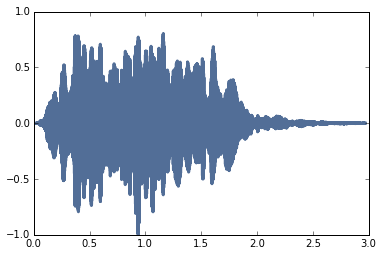

In [12]:
output.plot()

And we don't hear the extra note at the beginning:

In [13]:
output.make_audio()

We should get the same results from np.convolve and scipy.signal.fftconvolve.

First I'll get rid of the zero padding:

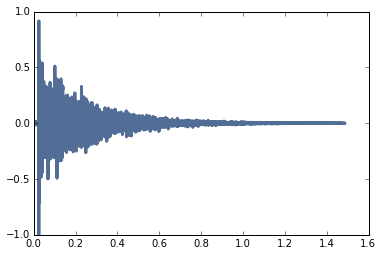

In [14]:
response.truncate(2**16)
response.plot()

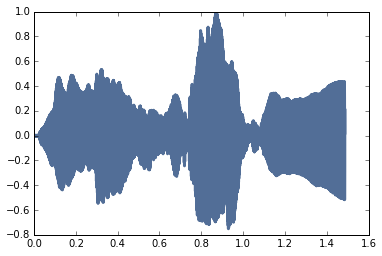

In [16]:
violin.truncate(2**16)
violin.plot()

Now we can compare to `np.convolve`:

In [17]:
output2 = violin.convolve(response)

The results are similar:

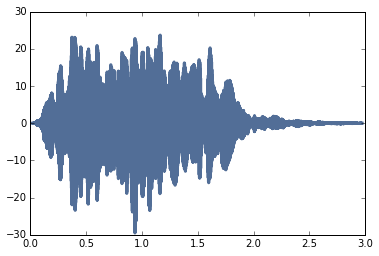

In [18]:
output2.plot()

And sound the same:

In [20]:
output2.make_audio()

But the results are not exactly the same length:

In [21]:
len(output), len(output2)

(131072, 131071)

`scipy.signal.fftconvolve` does the same thing, but as the name suggests, it uses the FFT, so it is substantially faster:

In [22]:
import scipy.signal
ys = scipy.signal.fftconvolve(violin.ys, response.ys)
output3 = thinkdsp.Wave(ys, framerate=violin.framerate)

The results look the same.

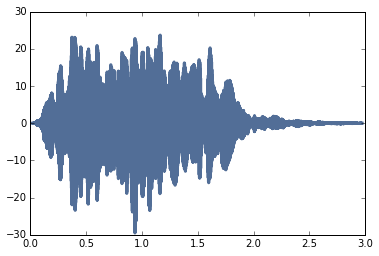

In [23]:
output3.plot()

And sound the same:

In [24]:
output3.make_audio()

And within floating point error, they are the same:

In [26]:
output2.max_diff(output3)

5.9507954119908391e-14

**Exercise:**  The Open AIR library provides a ``centralized... on-line resource for
anyone interested in auralization and acoustical impulse response
data'' (http://www.openairlib.net).  Browse their collection
of impulse response data and download one that sounds interesting.
Find a short recording that has the same sample rate as the impulse
response you downloaded.

Simulate the sound of your recording in the space where the impulse
response was measured, computed two way: by convolving the recording
with the impulse response and by computing the filter that corresponds
to the impulse response and multiplying by the DFT of the recording.

*Solution:* I downloaded the impulse response of the Lady Chapel at St Albans Cathedral http://www.openairlib.net/auralizationdb/content/lady-chapel-st-albans-cathedral

Thanks to Audiolab, University of York: Marcin Gorzel, Gavin Kearney, Aglaia Foteinou, Sorrel Hoare, Simon Shelley.


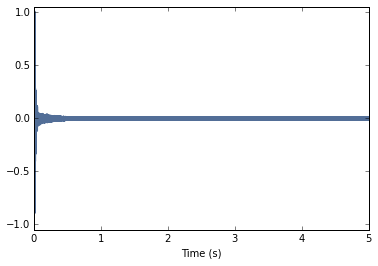

In [27]:
response = thinkdsp.read_wave('stalbans_a_mono.wav')

start = 0
duration = 5
response = response.segment(duration=duration)
response.shift(-start)

response.normalize()
response.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Here's what it sounds like:

In [28]:
response.make_audio()

The DFT of the impulse response is the transfer function:

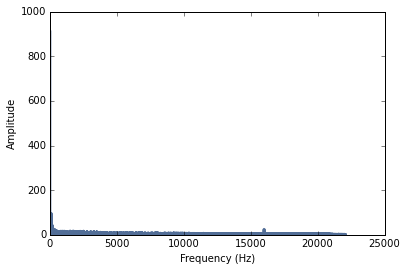

In [29]:
transfer = response.make_spectrum()
transfer.plot()
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude')

Here's the transfer function on a log-log scale:

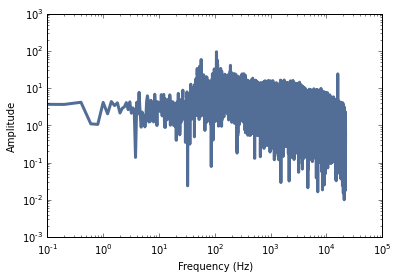

In [30]:
transfer.plot()
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude',
                 xscale='log', yscale='log')

Now we can simulate what a recording would sound like if it were played in the same room and recorded in the same way.  Here's the violin recording we have used before:

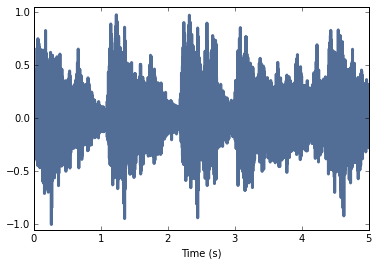

In [31]:
wave = thinkdsp.read_wave('170255__dublie__trumpet.wav')

start = 0.0
wave = wave.segment(start=start)
wave.shift(-start)

wave.truncate(len(response))
wave.normalize()
wave.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Here's what it sounds like before transformation:

In [32]:
wave.make_audio()

Now we compute the DFT of the violin recording.

In [33]:
spectrum = wave.make_spectrum()

I trimmed the violin recording to the same length as the impulse response:

In [34]:
len(spectrum.hs), len(transfer.hs)

(110251, 110251)

In [35]:
spectrum.fs

array([     0. ,      0.2,      0.4, ...,  22049.6,  22049.8,  22050. ])

In [36]:
transfer.fs

array([     0. ,      0.2,      0.4, ...,  22049.6,  22049.8,  22050. ])

We we can multiply in the frequency domain and the transform back to the time domain.

In [37]:
output = (spectrum * transfer).make_wave()
output.normalize()

Here's a  comparison of the original and transformed recordings:

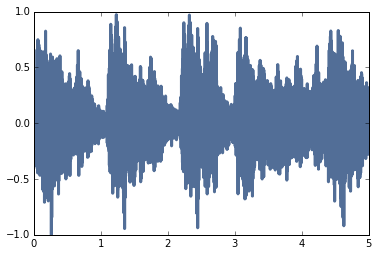

In [38]:
wave.plot()

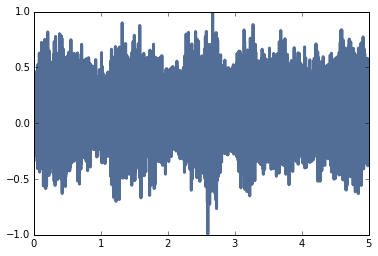

In [39]:
output.plot()

And here's what it sounds like:

In [40]:
output.make_audio()

Now that we recognize this operation as convolution, we can compute it using the convolve method:

In [41]:
convolved2 = wave.convolve(response)
convolved2.normalize()
convolved2.make_audio()